<a href="https://colab.research.google.com/github/project-ida/arpa-e-experiments/blob/main/analysis/nassisi-01/Nassisi_1b_Radiation_pulse_analysis_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="https://nbviewer.org/github/project-ida/arpa-e-experiments/blob/main/analysis/nassisi-01/Nassisi_1b_Radiation_pulse_analysis_updated.ipynb" target="_parent"><img src="https://nbviewer.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>


‼️ **Prerequisites** ‼️:
- Access to the `Nucleonics` Google drive folder (it must also be added as a shortcut called "Nucleonics" in your own drive)
- Access to the nucleonics `.env` folder (where sensitive info lives)

# Radiation pulse analysis

The analysis notebook relies on the "Nuclear particle master" sheet to provide timestamps for different phases of an experiment in order to perform bin-independent radiation analysis.

The aim is to develop techniques to characterise the background and detect anomalies in a way that minimises numerical artifiacts.


### Nassisi 1b

This notebook analyzes the second half of the Nassisi 1 experiment, recorded on channel 1 of the digitzer. The first half, recorded on channel 0, is analyzed in https://colab.research.google.com/drive/1qFW6Ggne_6p6yHn-tC0ftY3WJIZyXj37?authuser=2#scrollTo=PleVgUtQp_Zc

In [ ]:
experiment_id = 4
channel_number = 1

## Libraries

In [ ]:
# Auth
import sys, os
import shutil
from google.colab import drive
from google.colab import auth
from google.auth import default

# Interacting with sheets
import gspread

# Data analysis
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sqlalchemy import create_engine, text
from scipy.stats import kstest


#Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go

## Authentication

We need to do a few authentication steps:
- Bring in the database credentials from Google drive so that we can pull data from the live database.
- Bring in the nuclear particle master sheet ID.
-  Authenticate Colab to pull the nuclear particle master sheet using the Drive API.

In [ ]:
# Mount Drive
drive.mount('/content/drive')

# Copy SQL credentials from Google drive
shutil.copy("/content/drive/MyDrive/Nucleonics/.env/psql_credentials_readonly.py", "psql_credentials.py")

# Copy sheet ID file from Google drive
shutil.copy("/content/drive/MyDrive/Nucleonics/.env/sheet_ids.py", "sheet_ids.py");

Mounted at /content/drive


In [ ]:
# Import SQL credentials
from psql_credentials import PGUSER, PGPASSWORD, PGHOST, PGPORT, PGDATABASE

# Import sheet ID for the nuclear particle master sheet
from sheet_ids import NUCLEAR_PARTICLE_MASTER as sheet_id

# Create the database connection string
connection_uri = f'postgresql+psycopg2://{PGUSER}:{PGPASSWORD}@{PGHOST}:{PGPORT}/{PGDATABASE}'
engine = create_engine(connection_uri)

In [ ]:
# Authenticate using Colab's built-in credentials
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

## Extracting experimental timestamps

We need to
- Open the master sheet
- Find the row corresponding with the experiment
- Extract the timestamp columns

Because the master sheet is organised in blocks that share an experiment ID (to avoid visual overload) we'll need to "fill in" the experiment ID for all rows once the sheet is brought into a pandas dataframe.

In [ ]:
# Fill experiment IDs based on the block organisation of the master sheet
def fill_experiment_id(df):
    experiment_id = None
    updated_ids = []

    for index, row in df.iterrows():
        if pd.notna(row['Experiment ID']) and row['Experiment ID'] != '':
            experiment_id = row['Experiment ID']
        updated_ids.append(experiment_id)

    df['Experiment ID'] = updated_ids
    return df

In [ ]:
sheet = gc.open_by_key(sheet_id).sheet1

# Read the sheet into a pandas DataFrame
df = pd.DataFrame(sheet.get_all_records())

# Fill the experiment IDs based on the block organisation of the master sheet
df = fill_experiment_id(df)

In [ ]:
# Find the rows where Experiment ID matches
rows = df[df['Experiment ID'] == experiment_id]

if len(rows) == 0:
  raise ValueError(f"No matser sheet entry for 'Experiment ID' = {experiment_id}")

# Exract digitizer for SQL table identification
digitizer = rows.iloc[0]["Digitizer"]

# Extract times
times = rows.iloc[[0]][['Setup', 'Calibration', 'Background 1', 'Experiment', 'Background 2', 'End']]
times = times.apply(pd.to_datetime)

# Extract the row corresponding to the specified channel number
row = rows[rows["Digitizer channel number"] == channel_number]

if len(row) == 0:
  raise ValueError(f"No matser sheet entry for 'Experiment ID' = {experiment_id}, 'Digitizer channel number' = {channel_number}")

# Extract the psp neutron/gamma discriminator
psp = row["psp threshold"].iloc[0]

# Display the extracted times
times.head()

,Setup,Calibration,Background 1,Experiment,Background 2,End
7,NaT,NaT,NaT,2025-05-08 11:32:00,2025-06-06 11:00:00,2025-06-20 12:00:00


## Pulling the radiation events

We store each individual radiation pulse in our database. These pulses are characterised by an energy and a psp value. The radiation pulses contain a mixture of gamma and neutron events which can be distinguised through PSD analysis at different levels of sophistication.

The [simplest PSD analysis](https://github.com/project-ida/arpa-e-experiments/blob/main/tutorials/PSD_Analysis.ipynb) is to use a constant PSP discriminator value above which the pulses are considered to be neutrons, below are gammas. We can also combine this with an similar energy discriminator.

We can then query the database to pull only the events that match our PSD analysis requirements.

In [ ]:
def get_event_data(start_time, end_time, psp=">0", energy=">0"):
  query = f"""
  SELECT * FROM {digitizer}_ch{channel_number}
  WHERE channels[1] {psp} AND channels[2] {energy}
  AND time BETWEEN '{start_time}' AND '{end_time}'
  ORDER BY time;
  """
  df = pd.read_sql(query, engine, index_col=None)
  df.set_index('time', inplace=True)
  return df

We can now get all the event data for the different periods in the experiement.

In [ ]:
def get_all_event_data(times, psp=">0", energy=">0"):
  event_data = {}
  event_periods = {}
  columns = times.columns  # Include all columns, including 'Setup'

  for i in range(len(columns) - 1):  # Stop before the last column
      start_time = times.iloc[0, i]
      if pd.notna(start_time):
          # Find the next non-empty time
          end_time = None
          for j in range(i + 1, len(columns)):
              if pd.notna(times.iloc[0, j]):
                  end_time = times.iloc[0, j]
                  break
          # Only proceed if a valid end_time was found
          if end_time is not None:
              data = get_event_data(start_time, end_time, psp, energy)
              event_data[columns[i]] = data
              event_periods[columns[i]] = end_time - start_time

  return event_data, event_periods

## Neutron background analysis

We're going to look at the neutron events during the background phase of the experiment and perform an analysis to characterise the background. Often, analysis of this kind is performed by "binning" the data and looking at counts per second/minute/hour. While it is often more intuitive to view the radiation rates, in our analysis we will take a bin-indepedent view by analysing the time in between neutron events. This way, we avoid any artifacts of binning. We'll see what kind of artifacts can arrise shortly. Firstly, we need to filter out the neutrons from the gammas and reconstruct the neutron pulses to nanosecond precicison.

We can extract only the neutron events by using the psp values stored in the master spreadsheet.

In [ ]:
psp

0.203125

Note that this psp parameter is different from Nassisi 1a. There may have been some detector drift: the PSD vs Energy histogram is evidently different. It may be related to the digitizer channel change, but the channels should have the same paramters. More investigation is needed.

In [ ]:
#Set energy cutoff in channel
energy = 500

In [ ]:
neutron_data, neutron_periods = get_all_event_data(times, f">{psp}", f">{energy}")

### Reconstructing the pulses

Let's see what the pulse data looks like for the background. The background here is taken post-experiment in 13-3100.

In [ ]:
neutron_data["Background 2"].head()

,channels,ps,id
time,,,
2025-06-06 11:10:17.318955,"[0.21652639632746748, 2614.0]",318954706192,1977201153
2025-06-06 11:19:24.465788,"[0.26534653465346536, 505.0]",465788364410,1977210149
2025-06-06 11:59:48.037620,"[0.24432717678100263, 3790.0]",37620306015,1977249878
2025-06-06 12:28:21.002266,"[0.26095060577819196, 1073.0]",2266168594,1977277864
2025-06-06 12:29:34.613552,"[0.26785714285714285, 504.0]",613552093505,1977279049


The `channels` column gives `[psp, energy]`.

The database timestamp is limited in precision to microseconds, so we store the full picosecond precision in the `ps` columm. We therefore need to combine the time in microseconds with the picosecond time piece. It turns out that pandas only does datetime to nanoseconds so we'll have to discard some precision.

In [ ]:
def reconstruct_ns_pulses(df):
  # Floor the index to strip microseconds
  df.index = df.index.floor('s')

  # Convert picoseconds to nanoseconds
  df['ps_ns'] = df['ps'] // 1_000  # convert ps → ns

  # Create high-resolution timestamp
  df['timestamp'] = df.index + pd.to_timedelta(df['ps_ns'], unit='ns')

  # Set timestamp as index
  df.set_index('timestamp', inplace=True)

  # Create 'counts' column with value 1 for each row
  df['counts'] = 1

  # Drop all unneeded columns (including 'channels')
  df.drop(columns=['id', 'ps', 'ps_ns', 'channels'], inplace=True)

  # Sort by timestamp index
  df.sort_index(inplace=True)

  return df

We'll now reconstruct the nanosecond pulses for all the following experimental periods:

In [ ]:
neutron_data.keys()

dict_keys(['Experiment', 'Background 2'])

In [ ]:
for key, value in neutron_data.items():
  neutron_data[key] = reconstruct_ns_pulses(value)

### Inter-pulse distribution

During the background phase of the experiment, we expect to measure radiation pulses randomly over time - following a Poisson distribution. This distribution can be studied by looking at count rates - as we do in the [Eljen Detector Background Characterization](https://github.com/project-ida/arpa-e-experiments/blob/main/tutorials/Eljen-Background-Characterization.ipynb) notebook. Here, we will study the distribution by instead looking at the times between individual events.

For a Poisson process occuring at an average rate of $\lambda$, the probability that the time between events $\Delta t$ is less than some time $t$ is given by:

$$
P_{\rm Poisson}(\Delta t \le t) = 1 - e^{-\lambda t}
$$

We can estimate the $\lambda$ from the experimentally derived average inter-pulse time $\overline{\Delta t}$ via:

$$
\lambda = \frac{1}{\overline{\Delta t}}
$$

In [ ]:
background = neutron_data["Background 2"]

In [ ]:
deltas = np.diff(background.index.values).astype("timedelta64[ns]") / np.timedelta64(1, "s")
delta_sorted = np.sort(deltas)

In [ ]:
# Estimate lambda (rate in events per second)
lam = 1 / np.mean(delta_sorted)

# Calculate the theoretical distribution
P_poisson = 1 - np.exp(-lam * delta_sorted)

In [ ]:
lam

np.float64(0.0013202768378842826)

This rate is much lower than the initial background and soaking period, despite all being recorded in the same room (13-3100). It's possible this is due to the lower PSD value set for the first half of the experiment: a lower value could result in more gammas being counted as neutrons, especially if the PSP peaks drift up over time as the appear to have.

We've now got the theoretical inter-pulse distribution based on the assumption that the system indeed behaves like a Poisson process. How does the system really behave?

We need to calculate the cumulative distribution of events in order to compare with the Poisson probability distribution.

$$
P_{\rm exp}(\Delta t \le t) = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}\bigl(\Delta t_i \le t\bigr)
$$

In [ ]:
P_exp = np.arange(1, len(delta_sorted) + 1) / len(delta_sorted)

Let's see how the Poisson distribution compares to the experimental one.

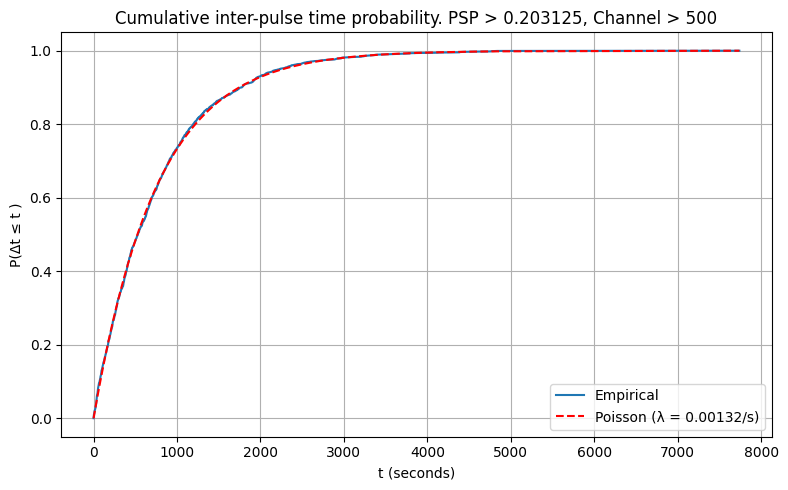

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(delta_sorted, P_exp, label="Empirical")
plt.plot(delta_sorted, P_poisson, linestyle="--", color="red", label=f"Poisson (λ = {lam:.5f}/s)")

plt.xlabel("t (seconds)")
plt.ylabel("P(Δt ≤ t )")
plt.title(f"Cumulative inter-pulse time probability. PSP > {psp}, Channel > {energy}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Visually, the level of agreement is superb. We can be more quantitative using a [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test), but we'll save this analysis for later in the notebook when we look at how to test for anomalies.

It's instructive to look at the cumulative pulses alongside the counts per minute.

In [ ]:
background_cpm = background.resample("60s").size().rename("counts").to_frame()
fig = go.Figure(layout=dict(yaxis_title="Counts per min", showlegend=False, height=600, width=800))
fig.add_trace(go.Scattergl(name="Counts per min", x=background_cpm.index, y=background_cpm.counts))

In [ ]:
neutron_periods["Experiment"]

Timedelta('28 days 23:28:00')

In [ ]:
experiment = neutron_data["Experiment"]
experiment_deltas = np.diff(experiment.index.values).astype("timedelta64[ns]") / np.timedelta64(1, "s")
experiment_delta_sorted = np.sort(experiment_deltas)

In [ ]:
# Estimate lambda for experiment period (rate in events per second)
experiment_lam = 1 / np.mean(experiment_delta_sorted)

# Calculate the theoretical distribution
experiment_P_poisson = 1 - np.exp(-experiment_lam * experiment_delta_sorted)

experiment_P_exp = np.arange(1, len(experiment_delta_sorted) + 1) / len(experiment_delta_sorted)

In [ ]:
experiment_lam

np.float64(0.0012682542105437787)

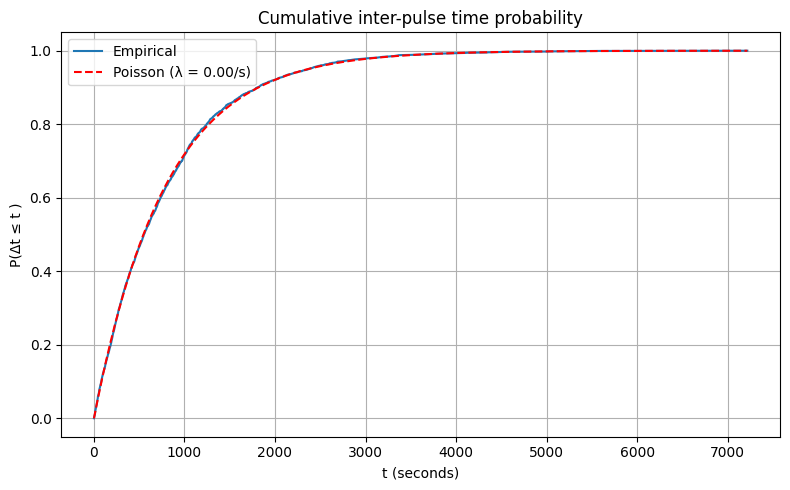

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(experiment_delta_sorted, experiment_P_exp, label="Empirical")
plt.plot(experiment_delta_sorted, experiment_P_poisson, linestyle="--", color="red", label=f"Poisson (λ = {experiment_lam:.2f}/s)")

plt.xlabel("t (seconds)")
plt.ylabel("P(Δt ≤ t )")
#plt.xlim([0,50])
plt.title("Cumulative inter-pulse time probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

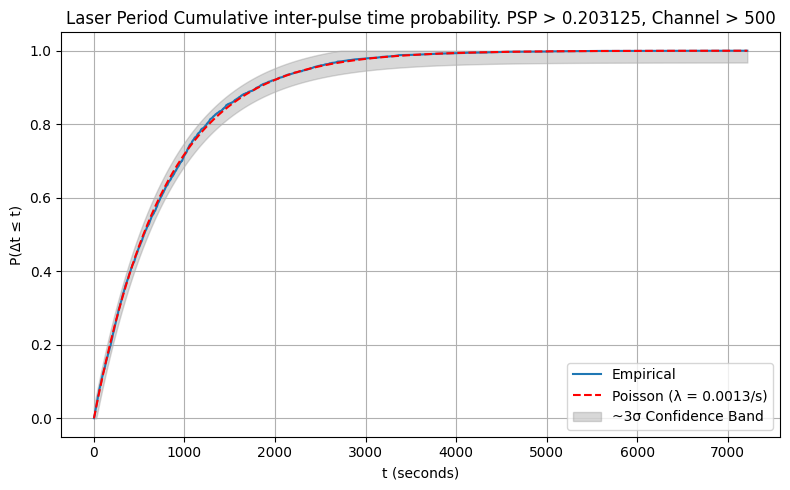

In [ ]:
# Number of samples (n)
n = len(experiment_delta_sorted)

# Desired confidence level (e.g. ~3σ = 99.7%)
alpha = 0.003

# Kolmogorov–Smirnov critical value for given alpha and n
D_alpha = np.sqrt(-0.5 * np.log(alpha / 2) / n)


# Upper and lower bounds of the confidence band
upper_bound = np.clip(experiment_P_poisson + D_alpha, 0, 1)
lower_bound = np.clip(experiment_P_poisson - D_alpha, 0, 1)

plt.figure(figsize=(8, 5))
plt.plot(experiment_delta_sorted, experiment_P_exp, label="Empirical")
plt.plot(experiment_delta_sorted, experiment_P_poisson, linestyle="--", color="red", label=f"Poisson (λ = {experiment_lam:.4f}/s)")
plt.fill_between(experiment_delta_sorted, lower_bound, upper_bound, color='gray', alpha=0.3, label="~3σ Confidence Band", zorder=1)

# # Max deviation marker and vertical line
# plt.plot(t_max_dev, cdf_with_synthetic_neutrons[max_index], 'ko', label="KS Statistic (D)")
# plt.vlines(t_max_dev, P_theory_at_synth[max_index], cdf_with_synthetic_neutrons[max_index], color='k', linestyles='dotted')

# # Annotate
# plt.annotate(f"D = {ks_statistic:.4f}", xy=(t_max_dev, cdf_with_synthetic_neutrons[max_index]),
#              xytext=(t_max_dev + 0.2, cdf_with_synthetic_neutrons[max_index] + 0.01),
#              arrowprops=dict(arrowstyle="->", lw=1), fontsize=9)

# Recompute bounds for synthetic burst dataset
#n_synth = len(synthetic_deltas_sorted)
#D_alpha_synth = np.sqrt(-0.5 * np.log(alpha / 2) / n_synth)
#P_poisson_synth = 1 - np.exp(-lam * synthetic_deltas_sorted)
#upper_bound_synth = np.clip(P_poisson_synth + D_alpha_synth, 0, 1)
#lower_bound_synth = np.clip(P_poisson_synth - D_alpha_synth, 0, 1)

#first_cross_index = np.argmax(
#    (cdf_with_synthetic_neutrons > upper_bound_synth) |
#    (cdf_with_synthetic_neutrons < lower_bound_synth)
#)

#plt.axvline(synthetic_deltas_sorted[first_cross_index], color='purple', linestyle=':', label="Statistical significance achieved")


plt.xlabel("t (seconds)")
plt.ylabel("P(Δt ≤ t)")
#plt.xlim([0,600])
#plt.ylim([0,0.2])
plt.title(f"Laser Period Cumulative inter-pulse time probability. PSP > {psp}, Channel > {energy}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
experiment_cpm = experiment.resample("60s").size().rename("counts").to_frame()
fig = go.Figure(layout=dict(yaxis_title="Counts per min", showlegend=False, height=600, width=1200))
fig.add_trace(go.Scattergl(name="Counts per min", x=experiment_cpm.index, y=experiment_cpm.counts))

The rate during the experiment period is slightly lower than the rate the in the background period. This could be due to the difference in location: the experiment period was recorded in the basement, 02-073. We will need to compare this rate with the background recorded in 02-073.

We have background recorded over a 24 hour period in 02-073 in February 2025, however it was recorded with the 4-channel digitizer. Careful analysis will need to be done to make a comparison.